In [1]:
# INPUT HERE ALL FOLDERS TO BE PREPROCESSED:
# all recordings and probes (except for LFP) within the following paths will be pre-processed.
# specify the path to a general folder containing multiple experiments, or be more specific if you need to exclude something:

base_npxpaths = [r"E:\Luigi_ephys\M24"]
                # r"G:\Paola Storage do not delete\RL_E1\E1_M18",
                # r"G:\Paola Storage do not delete\RL_E1\E1_M16",
run_barcodeSync = False
run_preprocessing = True # run preprocessing and spikesorting
callKSfromSI = False  # this remains insanely slow.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy.signal
import time
import os
import shutil
import json
import subprocess
from pathlib import Path
import torch

import spikeinterface.extractors as se
import spikeinterface.full as si
import spikeinterface.preprocessing as st
import spikeinterface.sorters as ss
from preprocessing_utils import make_probe_plots, standard_preprocessing

from probeinterface import ProbeGroup, write_prb
from probeinterface.plotting import plot_probe, plot_probe_group

from kilosort import io, run_kilosort

from pathlib import Path
from datetime import datetime
#%matplotlib  widget

n_cpus = os.cpu_count()
n_jobs = n_cpus - 4
print(n_jobs)
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

dtype = np.int16

16


In [3]:
#NEXT_FEATURES (tentative):
# add programmatic call to KS (not via SI - or perhaps not without saving preprocessed data to disk.. otherwise takes impossibly long)

# # add an option to either save data.bin and ks output to a different drive/location if a faster drive is available, and then transfer it all to the original destination

In [4]:

found_paths = [] #List to store all found paths
target_file = 'structure.oebin'

def search_files(base_path, target_file):
    for dirpath, dirnames, filenames in os.walk(base_path):
        if target_file in filenames:
            found_paths.append(dirpath)

for path in base_npxpaths:
    search_files(path, target_file)

if found_paths:
    print("Will be processing all probes from the following recordings:")
    for path in found_paths:
        print(path)
        full_path = os.path.join(path, target_file)
        with open(full_path, 'r') as file:
            file_contents = file.read()
            data = json.loads(file_contents)
            continuous_data = data['continuous']
            indices_notLFP = [index for index, folder in enumerate(continuous_data)
                                   if "LFP" not in folder['folder_name'] and "NI-DAQ" not in folder['folder_name']]
            for index in indices_notLFP:
                stream_name = continuous_data[index]['stream_name']
                print(stream_name)
else:
    print("File 'structure.oebin' not found in any of the specified directories")

    
# log relevant preprocessing metadata
now = datetime.now()
formatted_time = now.strftime('%Y%m%d_%H%M%S')
logfilename = f"log_preprocessing_{formatted_time}.json" 
# initialize a dictionary that will be updated dynamically
log_metadata = {
    "recording": []
}
print(indices_notLFP)

Will be processing all probes from the following recordings:
E:\Luigi_ephys\M24\2024-04-24_10-00-55\Record Node 103\experiment1\recording1
ProbeA-AP
ProbeB-AP
[0, 2]


In [5]:
# find json file with recording structure
from pprint import pprint
base_path = base_npxpaths[0]

def find_recinfo_file(base_path, target_file='structure.oebin'):
    file_path = list(Path(base_path).rglob(target_file))
    assert len(file_path) == 1, f"Found {len(file_path)} files with name {target_file} in {base_path}. Please specify a single file."
    return file_path[0]

def read_continuous_data_info(recinfo_file):
    with open(recinfo_file, 'r') as f:
        file_contents = f.read()
        rec_info = json.loads(file_contents)
    # pprint(rec_info)
    return rec_info["continuous"]

def get_channel_names(continuous_data_info):
    string_to_exclude = ['LFP', 'NI-DAQ']
    # recinfo = load_recinfo(base_path)
    all_folders = []
    ap_folders = []
    for folder in continuous_data_info:
        stream_name = folder["recorded_processor"] + " " + str(folder["recorded_processor_id"]) + "#" + folder['folder_name'][:-1]
        all_folders.append(stream_name)

        if all([string not in folder['folder_name'] for string in string_to_exclude]):
            ap_folders.append(stream_name)
    
    return all_folders, ap_folders

recinfo_file = find_recinfo_file(base_path)
continuous_data_info = read_continuous_data_info(recinfo_file)
all_stream_names, ap_stream_names = get_channel_names(continuous_data_info)

In [6]:
# if sync data were collected through openephys, you can proceed directly (if you read this, it might need debugging)

# if sync data were collected through intan (legacy), pause here and extract the barcode files first (done in matlab)
# then move the SynchData folder to the corresponding paths shown above
for path in found_paths:
    sync_folder = Path(os.path.join(path, 'SynchData')) # please do not change the spelling
    sync_folder.mkdir(exist_ok=True)
    print(sync_folder)

E:\Luigi_ephys\M24\2024-04-24_10-00-55\Record Node 103\experiment1\recording1\SynchData


new dir:  E:\Luigi_ephys\M24\2024-04-24_10-00-55\Record Node 103\experiment1\recording1\SpikeData_Record Node 103#Neuropix-PXI-100.ProbeA-AP
Stream name:  Record Node 103#Neuropix-PXI-100.ProbeA-AP
OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 195,617,676 samples 
                                   6,520.59s (1.81 hours) - int16 dtype - 139.92 GiB
Estimated LSB value: 12


NameError: name 'ks_folder' is not defined

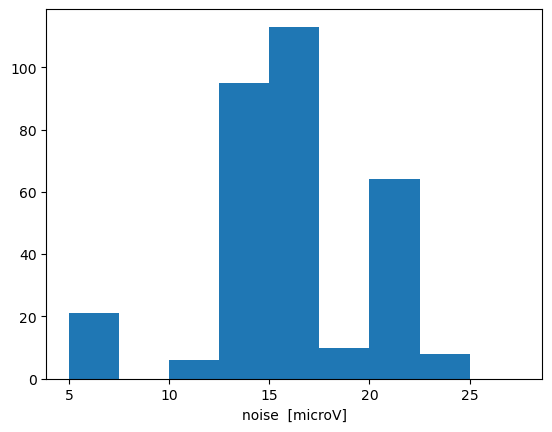

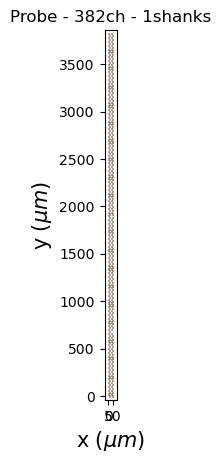

In [7]:
run_barcodeSync = False
run_preprocessing = True # run preprocessing and spikesorting
callKSfromSI = False  # this remains insanely slow.

for base_path in base_npxpaths:
    recinfo_file = find_recinfo_file(base_path)
    continuous_data_info = read_continuous_data_info(recinfo_file)
    all_stream_names, ap_stream_names = get_channel_names(continuous_data_info)

    # extra step to correct for bad timestamps from failed online synchronization here:
    sync_folder = Path(path) / 'SynchData'  # please do not change the spelling
    
    if run_barcodeSync:
        sync_folder.mkdir(exist_ok=True)
        
        for continuous_stream_info in continuous_data_info:
            foldername = continuous_stream_info['folder_name']
            stream_name = continuous_stream_info['stream_name']
            sample_rate = continuous_stream_info['sample_rate']
            workdir = os.path.join(path, 'continuous', foldername)
            sn = np.load(os.path.join(workdir, 'sample_numbers.npy'))
            ts = sn.astype(np.float64)
            ts = ts/sample_rate
            ts = ts.reshape(-1,1) #make it consistent with what is required downstream, and with what is saved by matlab
            print(ts.shape)
            np.save(os.path.join(sync_folder, "timestamps_{}.npy".format(stream_name)), ts)
            # also retrieve all the barcode files and copy them to the same sync folder
            workdir_events = os.path.join(path, 'events', foldername, 'TTL')
            source_path = os.path.join(workdir_events, 'sample_numbers.npy')
            destination_path = os.path.join(sync_folder, "sample_numbers_{}.npy".format(stream_name))
            shutil.copy(source_path, destination_path)
        
        # run barcode synchronization:
        command = ['python', 'barcode_sync_full.py', sync_folder]
        result = subprocess.run(command, capture_output=True, text=True)
        print("Output:", result.stdout)
        if result.stderr:
            print("Error:", result.stderr)
        

    # collect spikedata streams info:
    spikedata = {
        "SpikeData": []
    }
    for continuous_stream_info in continuous_data_info:
        foldername = continuous_stream_info['folder_name']
        stream_name = continuous_stream_info['stream_name']

        ks_folder = Path(os.path.join(path, "SpikeData_{}".format(stream_name)))
        new_spikedata = {
            "stream_name": stream_name,
            "path": ks_folder.parts
        }
        spikedata["SpikeData"].append(new_spikedata)
    
    p = Path(path)
    # update and write metadata file:
    if run_barcodeSync:
        new_recording = {
            "recording_path": p.parts,
            "SynchData_path": sync_folder.parts,
            "barcodeSync_output": result.stdout,
            "barcodeSync_error": result.stderr,
            "SpikeData": spikedata["SpikeData"]
        }
    else:
        new_recording = {
            "recording_path": p.parts,
            "SynchData_path": sync_folder.parts,
            "SpikeData": spikedata["SpikeData"]
        }
    log_metadata["recording"].append(new_recording)
    with open(logfilename, 'w') as file:
        json.dump(log_metadata, file, indent=4)
    
    
    if run_preprocessing:
        # go on with preprocessing
        for stream_name in ap_stream_names:
            # stream_name = continuous_data[index]['stream_name']
            # print(index, stream_name)

            ks_folder = Path(path) / "SpikeData_{}".format(stream_name)
            ks_folder.mkdir(exist_ok=True)
            
            print("new dir: ", ks_folder)
            recording_raw = se.read_openephys(folder_path=path, stream_name=stream_name, load_sync_channel=False) # this maps all streams even if you specify only one
            print("Stream name: ", recording_raw.stream_name)
            print(recording_raw)

            fs = recording_raw.get_sampling_frequency()


            # preprocessing steps
            recording_hpsf = standard_preprocessing(recording_raw)

            # save probe information (as dataframe, plus figure)
            make_probe_plots(recording_raw, recording_hpsf, ks_folder)

In [ ]:

ts = np.load(r'G:\Paola Storage do not delete\RL_E1\E1_M16\NPXData\2024-04-12_12-24-02\Record Node 101\experiment1\recording1\SynchData\timestamps_ProbeB-LFP_alignedTo_ProbeB-AP.npy')
print(ts)          
             

In [ ]:
# if save2path.is_dir():
#     recording_saved = si.read_zarr(save2path)    # reczarr = si.load_extractor(save2path) #achieve the same...
# else:
#     #recording_saved = recording_hpsf.save(save2path, **job_kwargs)
#     import numcodecs
#     compressor = numcodecs.Blosc(cname="zstd", clevel=5, shuffle=numcodecs.Blosc.BITSHUFFLE)
#     recording_saved = recording_hpsf.save(format="zarr", folder=save2path,
#                                          compressor=compressor,
#                                          **job_kwargs)
# elapsed_time = time.time() - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
# print("CR custom:", recording_saved.get_annotation("compression_ratio"))

In [ ]:
# noise_levels_unscaled = si.get_noise_levels(recording_saved, return_scaled=False)
# fig, ax = plt.subplots()
# _ = ax.hist(noise_levels_unscaled, bins=np.arange(5, 30, 2.5))
# ax.set_xlabel('noise')

# from spikeinterface.sortingcomponents.peak_detection import detect_peaks
# from spikeinterface.sortingcomponents.peak_localization import localize_peaks

# peaks = detect_peaks(recording_saved,  method='locally_exclusive', noise_levels=noise_levels_unscaled,
#                      detect_threshold=5, radius_um=50., **job_kwargs)
# peak_locations = localize_peaks(recording_saved, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

# fig, ax = plt.subplots(figsize=(10, 8))
# ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.02)

# elapsed_time = time.time() - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
# print("CR custom:", recording_saved.get_annotation("compression_ratio"))

In [ ]:
# # optional module here:
# motion_folder = Path(os.path.join(npxpath, 'motioncorrection'))
# rec_corrected, motion_info = st.correct_motion(recording=recording_saved, preset="nonrigid_accurate", folder=motion_folder, output_motion_info=True, **job_kwargs)
# # motion_info = st.load_motion_info(motion_folder)
# # and plot
# fig = plt.figure(figsize=(14, 8))
# si.plot_motion(motion_info, figure=fig, depth_lim=(400, 600),
#                color_amplitude=True, amplitude_cmap='inferno', scatter_decimate=10)